# 2. Batch Data Processing - Batch processing of  Electronic Medical Reports (EMR) with Amazon Comprehend Medical

In the previous module, [1.Data_Processing](./1.Data_processing.ipynb), we learnt how to extract medical information from a single PDF medical report using Textract and Comprehend Medical. In this module, we will use the same pre-processing methodology, but to minimise processing time and cost, we will be processing a batch of medical reports in textual format using Comprehend Medical and skipping the Textract step. We use this output from Comprehend Medical as our dataset to train our machine learning model.

## Contents

1. [Objective](#Objective)
1. [Background](#Background)
1. [Setup Environment](#Setup-Environment)
1. [Load and Explore Data](#Load-and-Explore-Data)
   + Load MTSamples data
   + Remove samples with missing transcriptions
   + Explore data distribution
   + Extract medical information from data using Comprehend Medical
   + Organize medical conditions
1. [Data Sampling](#Data-Sampling)
   + Sampling for patients for Surgery
   + Sampling for patients for consultation
1. [Combine samples](#Combine-the-dataset)
1. [Save the File](#Save-the-File)

---
## Objective 
This notebook is the preprocessing step to prepare a batch of medical records for model training. Specifically, you will use Comprehend Medical to extract medical terms from doctors's transcripts and organize them into data frame.

---

## Background

**Dataset**: Medical transcription data scraped from mtsamples.com. The target in the preprocess is to extract the medical conditions from doctors' notes, and then organized into dataset for modeling. In the next step, we will use the processed dataset to correctly classify the medical specialties based on the transcription text. In real life, the model can be used for automatic reference to respective specialist.

**Amazon Comprehend Medical**: Comprehend Medical detects useful information in unstructured clinical text. As much as 75% of all health record data is found in unstructured text such as physician's notes, discharge summaries, test results, and case notes. Amazon Comprehend Medical uses Natural Language Processing (NLP) models to sort through text for valuable information.

**Supported Languages**: Amazon Comprehend Medical only detects medical entities in English language texts.

---
## Setup Environment

Before we begin, let us setup our environment, will be doing the following:

- **import** some useful libraries (as in any Python notebook)
- **configure** the S3 bucket and folder where data should be stored (to keep our environment tidy)
- **connect** to Amazon Comprehend(with [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)) and SageMaker in particular (with the [sagemaker SDK](https://sagemaker.readthedocs.io/en/stable/)), to use the cloud services

Note: While `boto3` is the general AWS SDK for Python, `sagemaker` provides some powerful, higher-level interfaces designed specifically for ML workflows.

In [1]:
import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
import time
import os
from util.preprocess import *  # helper function for classification reports

# setting up SageMaker parameters
import sagemaker
import boto3

import matplotlib.pyplot as plt
import seaborn as sns

boto_session = boto3.Session()
region = boto_session.region_name
bucket_name = sagemaker.Session().default_bucket()
bucket_prefix = "emr-mtSample"  # Location in the bucket to store our files
sgmk_session = sagemaker.Session()

sgmk_client = boto_session.client("sagemaker")  ## API for sagemaker
cm_client = boto3.client(service_name='comprehendmedical', use_ssl=True, region_name = 'us-east-1') ## API for comprehend medical

---
## Load and Explore Data

For this workshop, we have already included the MTSamples dataset in your local folder (`./data/mtsample.csv`). You can find the raw dataset is available at [kaggle](https://www.kaggle.com/tboyle10/medicaltranscriptions). 

**Columns in the dataset**:

* `description`: Short description of transcription (string)
* `medical_specialty`: Medical specialty classification of transcription (string)
* `sample_name`: Transcription title
* `transcription`: Transcribed doctors' notes
* `keywords`: Relevant keywords from transcription

In the next section of our workshop, [3.Model building, training and deployment](./3.Model_building_training_and_development.ipynb), we will be building a machine learning model to classify medical reports based on the transcription. But before we can do that, we need to extract data from the MTSamples dataset. To train our model, we will be extracting the medical information from  the `transcription` column using Amazon Comprehend Medical. We will also be using the `medical_specialty`column as our labels for our classification model.

In [2]:
df=pd.read_csv("./data/mtsamples.csv")
df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


### Clean up dataset

Before we process our dataset, let us check for empty columns and remove them.

In [3]:
df.isnull().sum(axis=0) ## check for missing information

description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

### Explore dataset by medical speciality

Let us do some data exploration and observe the distribution of medical reports by medical speciality

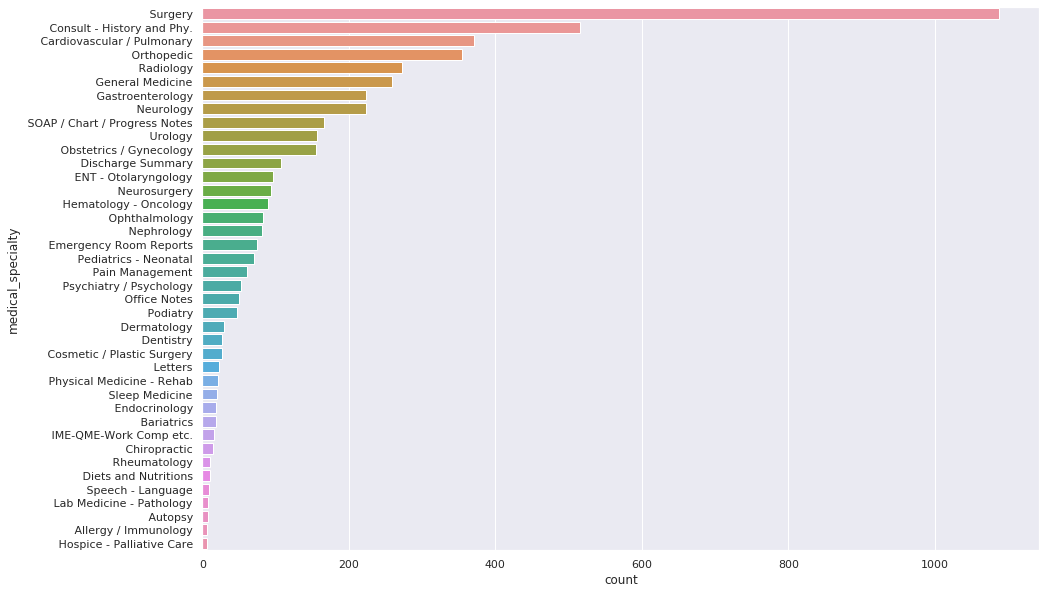

In [4]:
## add patient_id for reference
df=df[df.transcription.isnull()==False].reset_index()
df['id']=df.index
sns.set(rc={'figure.figsize':(15,10)})
sns.countplot(y='medical_specialty',order=df['medical_specialty'].value_counts().index, data=df)  #df.medical_specialty.value_counts()

---
## Data-Sampling

#### Data Sampling 1 - Surgery
As we can observe in the chart above, we have 1000+ medical reports that have been classified under the **Surgery** medical speciality. Let us dive deeper and randomly select 200 patients from the **Surgery** category and extract the medical conditions using Amazon Comprehend Medical.

In [7]:
%%time
nSample=20 ##<specify a number to process the medical terms in a batch >
medical_specialty=' Surgery'
df_phyList1,patient_ids=subpopulation_comprehend(df, medical_specialty,sampleSize=nSample)

  0%|          | 0/20 [00:00<?, ?it/s]

original data shape is  (20, 8)
data shape after removing missing entries is  (20, 8)


100%|██████████| 20/20 [02:04<00:00,  6.24s/it]

CPU times: user 178 ms, sys: 9.59 ms, total: 188 ms
Wall time: 2min 4s


#### Distributions of medical conditions

Now that we have extracted the medical conditions using Amazon Comprehend Medical, let us take a look at the most common medical conditions observed in the medical reports.

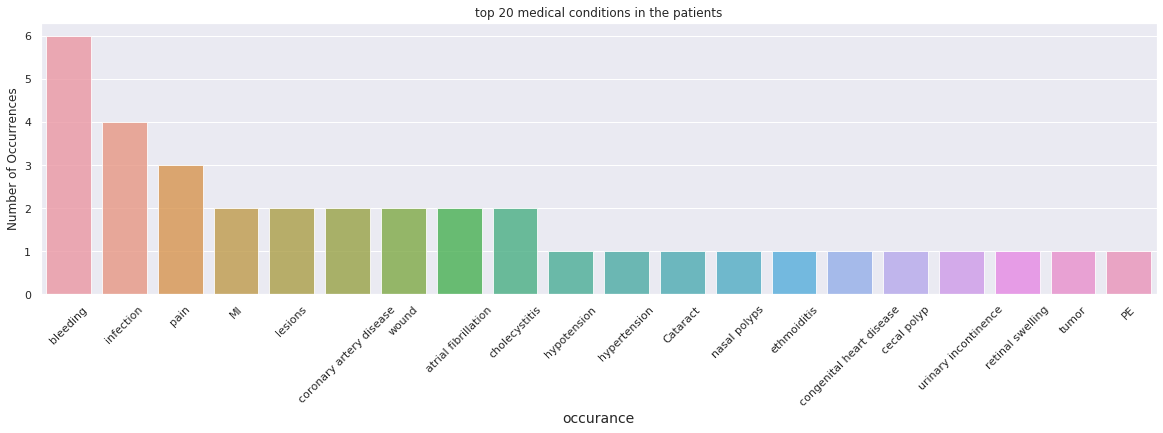

bleeding              6
infection             4
pain                  3
MI                    2
lesions               2
                     ..
hemorrhoidal bleed    1
hemostasis            1
nasal obstruction     1
diaphoretic           1
numbness              1
Name: MEDICAL_CONDITION, Length: 69, dtype: int64

In [8]:
## organize into a dataframe
df_extracted_surg=extractMCbatch(df_phyList1,patient_ids)
## plot the results
topN=20 ## the number for top conditions
threshold_score=0.9
mc_barplot(df_extracted_surg, threshold_score,topN)

#### Data Sampling 2 - *Consult - History and Phy*

Let us pick another medical speciality we want to try and classify. Let us pick 200 medical reports from the next most popular medical speciality - *Consult - History and Phy*.

In [9]:
%%time
nSample=20 ##<specify a number to process the medical terms in a batch >
medical_specialty=' Consult - History and Phy.'
df_phyList,patient_ids=subpopulation_comprehend(df, medical_specialty,sampleSize=nSample)

  0%|          | 0/20 [00:00<?, ?it/s]

original data shape is  (20, 8)
data shape after removing missing entries is  (20, 8)


100%|██████████| 20/20 [04:11<00:00, 12.59s/it]

CPU times: user 242 ms, sys: 3.28 ms, total: 245 ms
Wall time: 4min 11s


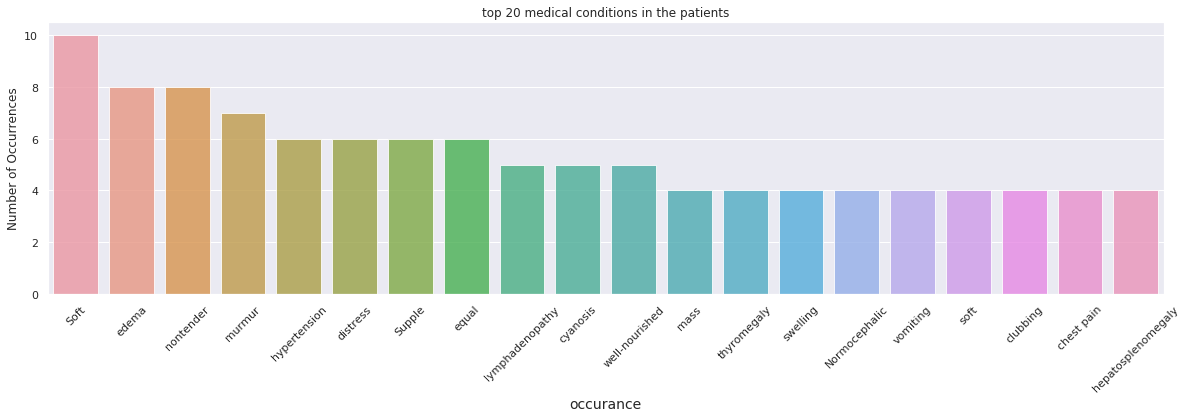

Soft                   10
edema                   8
nontender               8
murmur                  7
hypertension            6
                       ..
sickle cell anemia      1
nipple discharge        1
esophageal cancer       1
Sensorium stuporous     1
homicidal ideations     1
Name: MEDICAL_CONDITION, Length: 376, dtype: int64

In [10]:
## organize into a dataframe
df_extracted_consult=extractMCbatch(df_phyList,patient_ids)
## plot the results
topN=20 ## the number for top conditions
threshold_score=0.9
mc_barplot(df_extracted_consult, threshold_score,topN)

## Combine-the-dataset

Now that we've picked two medical speciality we want to classify, let us consolidate this data and save it for the next part of the workshop.

In [11]:
from imp import reload
from  util import preprocess
reload(preprocess)
#from util.preprocess import subpopulation_comprehend,retrieve_mcList

<module 'util.preprocess' from '/home/ec2-user/SageMaker/aws-ml-healthcare-workshop/util/preprocess.py'>

In [12]:
mcList1, df_grp1=preprocess.retrieve_mcList(df_extracted_surg)

In [13]:
mcList2, df_grp2=preprocess.retrieve_mcList(df_extracted_consult)

In [14]:
df_grp1['Label']=True # group one is Labeled as True 
df_grp2['Label']=False  # group two is Labeled as True 


df_combined=df_grp1.append(df_grp2) ## append two data frames 
mcLists=list(set(mcList1+mcList2))

df_combined2=preprocess.df_mc_generator(df_combined,mcLists ,colname_other=['ID',"Label"] )

## Save the File

In [15]:
df_combined2.to_csv("./data/processed_combined_wide_v1.csv",index=False)